In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

https://github.com/lukemelas/PyTorch-Pretrained-ViT/blob/master/pytorch_pretrained_vit/utils.py  
Load pretraind vision transformer model and fine tune with medical image.  
Use positional embedding interpolation (from pre to fine, resolution is 256? -> 384)  
class num should be changed to 2  
batch size : from 16 to 8  
learning rate : 0.00008 -> 0.00004
<!-- resize_positional_embedding=(image_size != pretrained_image_size) -->
positional embedding은 weight load시 자동으로 interpolation하도록 구현되어 있음  
CPU memory increase linearly. need to check memory leakage.  
use loss.item() instead of loss
(the computation graph is unintentionally stored somewhere)  
loss는 tensor 객체이다. 객체가 아닌 value를 더해줘야 한다.

resnet과 비교  
resnet152  
batchsize :16, 
learning rate : 0.00008, 
gpu mem : 10.3G, 
training time : 17 mins, 
Recall 0.5342 precision 0.7273, accuracy 0.8468, F1 score 0.616

resnet152 with amp  
batchsize :32,  
learning rate : 0.00008, 
gpu mem : 10.5G, 
training time : 15 mins, 
Recall 0.645 precision 0.6667, accuracy 0.8441, F1 score 0.6556  
  
vit base
batchsize :8, 
learning rate : 0.00004,
transformation시 normalization 추가,  
gpu mem : 10.3G, 
training time : 26mins, 
Recall 0.6189 precision 0.6323, accuracy 0.8295, F1 score 0.6255

공통
loss : focal loss(for train/eval)  
fine tuning시 resolution 384  
8 epochs



In [2]:
!pwd
!nvidia-smi

/kaggle/working
Tue Feb 16 03:33:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                        

In [3]:
# !wget http://www.image-net.org/challenges/LSVRC/2012/nnoupb/ILSVRC2012_img_val.tar

In [4]:
!pip install pytorch_pretrained_vit

  Created wheel for pytorch-pretrained-vit: filename=pytorch_pretrained_vit-0.0.7-py3-none-any.whl size=11131 sha256=429afa90581fc41e4111f97b89e72842a1a60aa642d13361fbdc83232c6e8327
  Stored in directory: /root/.cache/pip/wheels/87/1d/d1/c6852ef6d18565e5aee866432ab40c6ffbd3411d592035cddb
Successfully built pytorch-pretrained-vit


In [5]:
# from pytorch_pretrained_vit import ViT
# model = ViT('B_16_imagenet1k', pretrained=True)

In [6]:
!ls -al ../input/dogs-image

total 84
drwxr-xr-x 2 nobody nogroup     0 Feb 14 16:02 .
drwxr-xr-x 4 root   root     4096 Feb 16 03:33 ..
-rw-r--r-- 1 nobody nogroup 80327 Feb 14 16:02 dog.jpg


In [7]:
path = '../input/dogs-image/dog.jpg'

In [8]:
# import json
# from PIL import Image
# import torch
# from torchvision import transforms

# # Load ViT
# from pytorch_pretrained_vit import ViT
# model = ViT('B_16_imagenet1k', pretrained=True, num_classes=2)
# model.eval()

# # Load image
# # NOTE: Assumes an image `img.jpg` exists in the current directory
# img = transforms.Compose([
#     transforms.Resize((384, 384)), 
#     transforms.ToTensor(),
#     transforms.Normalize(0.5, 0.5),
# ])(Image.open(path)).unsqueeze(0)
# print(img.shape) # torch.Size([1, 3, 384, 384])

# # Classify
# with torch.no_grad():
#     outputs = model(img)
# print(outputs.shape)  # (1, 1000)

In [9]:
# # print(outputs)
# print(torch.argmax(outputs))

In [10]:
# import libs
import os
import glob, pylab, pandas as pd
import pydicom, numpy as np
import random
import json
import time
import copy
import pydicom
import torchvision
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision import datasets, transforms
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from pathlib import Path

import torch.nn.functional as F

# from fastai.conv_learner import *
# from fastai.dataset import *
# from fastai.dataset import ImageClassifierData

In [11]:
PATH = '../input/rsna-pneumonia-detection-challenge/'
df = pd.read_csv(PATH + 'stage_2_train_labels.csv')
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [12]:
# print(df.drop_duplicates('patientId').shape)
# len(list((PATH + 'stage_2_train_images').iterdir()))
print(len(os.listdir(PATH + 'stage_2_train_images')))
df = df.drop_duplicates('patientId').reset_index(drop=True)
print(df.shape)
print(df.head())

26684
(26684, 6)
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


In [13]:
# df = df[0:2000]
train_df, test_df = train_test_split(df, test_size=0.1, random_state=0)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
print(train_df.shape)
print(test_df.shape)

print(len(df[df['Target']==1])/len(df))
print(len(train_df[train_df['Target']==1])/len(train_df))
print(len(test_df[test_df['Target']==1])/len(test_df))


(24015, 6)
(2669, 6)
0.225303552690751
0.22477618155319593
0.23004870738104158


In [14]:
train_df.head()

,patientId,x,y,width,height,Target
0,d0183e7f-16b5-4dec-9190-2141bc78f683,NaN,NaN,NaN,NaN,0
1,fdeff9e3-54ca-487e-a00b-71c9072eed25,NaN,NaN,NaN,NaN,0
2,6b033062-62d0-4506-8dda-d3f5df1ee117,NaN,NaN,NaN,NaN,0
3,9ec108de-18b4-4446-a6e8-4c398f5a6614,209.0,429.0,187.0,204.0,1
4,f01452c9-636e-47e9-b126-33be9892fdc5,NaN,NaN,NaN,NaN,0


In [15]:
class MDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transforms.Compose(transform) if transform else None
        self.dir = PATH + 'stage_2_train_images/'

    def __len__(self):
        return len(self.df)
    
    def read_dicom_image(self, loc):
        # return numpy array
        img_arr = pydicom.read_file(loc).pixel_array
        img_arr = img_arr/img_arr.max()
        img_arr = (255*img_arr).clip(0, 255).astype(np.uint8)
        img_arr = Image.fromarray(img_arr).convert('RGB') # model expects 3 channel image
        return img_arr    

    def __getitem__(self, idx):
        pid = self.df.iloc[idx, 0]
#         print(pid)
        filepath = [] 
        filepath.append(self.dir) 
        filepath.append(pid) 
        filepath.append('.dcm')
        filepath = ''.join(filepath)
        pimage = self.read_dicom_image(filepath)
        if self.transform:
            pimage = self.transform(pimage)
        label = self.df.iloc[idx, 5]
        return pid, pimage, label

In [16]:
BATCH_SIZE = 32
transform = [transforms.Resize(384), transforms.RandomHorizontalFlip() , transforms.ToTensor()]
# transform = [transforms.Resize(384), transforms.RandomHorizontalFlip() , transforms.ToTensor(), 
#             transforms.Normalize(0.5, 0.5)]

train_dataset = MDataset(train_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_dataset = MDataset(test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [17]:
#https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
# focal loss for unbalancing label
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
#         self.device = torch.device('cuda')
#         self.alpha = alpha.to(self.device)
        self.alpha =alpha
        self.gamma = gamma
        self.reduce = reduce
        self.loss = F.cross_entropy
#         print(alpha)
#         print(type(alpha))

    def forward(self, inputs, targets):
        CE_loss = self.loss(inputs, targets, reduce=False)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * CE_loss
#         CE_loss = self.loss(inputs, targets, reduce=False, weight=self.alpha)
#         pt = torch.exp(-(self.loss(inputs, targets, reduce=False)))
# #         pt = torch.exp(-CE_loss)
#         F_loss = (1-pt)**self.gamma * CE_loss        

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss    

In [18]:
# https://gist.github.com/SuperShinyEyes/dcc68a08ff8b615442e3bc6a9b55a354
class F1_Loss(nn.Module):
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. epsilon <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    - http://www.ryanzhang.info/python/writing-your-own-loss-function-module-for-pytorch/
    '''
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true,):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, 2).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)
        
        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
        return 1 - f1.mean()

In [19]:

model= torchvision.models.resnet152(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) # target label is 2

# # Load ViT
# from pytorch_pretrained_vit import ViT
# model = ViT('B_16_imagenet1k', pretrained=True, num_classes=2)

# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss(alpha=0.97, gamma=2, reduce=True)
# criterion = F1_Loss()
# model_ft = model.cuda()

# # save for ensemble
# default_model = copy.deepcopy(model.state_dict())

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.00008)

dev = "cuda"
# dev = "cpu"
device = torch.device(dev)
model.to(device)

criterion = criterion.to(device)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

scheduler = lr_scheduler.LambdaLR(
    optimizer=optimizer, lr_lambda=lambda epoch: 1 / (epoch + 1)
)

scaler = torch.cuda.amp.GradScaler()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [20]:
def model_eval(model, criterion, dev='cuda' ) :
#     print('evaluation mode')
    device = torch.device(dev)
    criterion = criterion.to(device)
    model.to(device)
    model.train(False)
    data_loader = test_loader
    running_corrects = 0
    test_loss = 0
    
    # accuracy and loss
    with torch.no_grad():    
        for _, pimages, labels in data_loader:
#             pimages = torch.tensor(pimages)
#             labels = torch.tensor(labels)
            pimages, labels = pimages.to(device), labels.to(device)  
            outputs = model(pimages)  
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs.data, 1)  
            running_corrects += torch.sum(preds == labels.data)
            test_loss += loss.item()*pimages.size()[0]
        epoch_acc = running_corrects / len(data_loader.dataset)
#     print('{} loss: {:.4f} Acc: {:.4f}'.format(
#         'test',test_loss/len(data_loader.dataset), epoch_acc))   
    
    return (epoch_acc, test_loss/len(data_loader.dataset))

In [21]:
def one_epoch_train(model, optimizer, criterion) :
    running_loss = 0.0
    running_corrects = 0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        _, pimages, labels = data
#         pimages = torch.tensor(pimages)
#         labels = torch.tensor(labels)
#         pimages = labels.clone().detach()
        labels = labels.clone().detach()
        pimages, labels = pimages.to(device), labels.to(device)

        with torch.cuda.amp.autocast():
            outputs = model(pimages)
            loss = criterion(outputs, labels)
        _, preds = torch.max(outputs.data, 1)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # statistics
        running_loss += loss.item() * pimages.size()[0]
        running_corrects += torch.sum(preds == labels.data) 

#         loss.backward()
#         optimizer.step()   
      
    return running_loss, running_corrects


In [22]:
import time
def model_train(model, optimizer, criterion, scheduler) :  
    # model.train(True)
    best_test_acc = 0
    best_f1_loss = 100

    train_loss = []
    test_loss = []
    best_model_wts = copy.deepcopy(model.state_dict())
   
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 50)
        start = time.time()
        model.train(True)
    
        running_loss,running_corrects = one_epoch_train(model, optimizer, criterion)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss.append(float(epoch_loss))
        epoch_acc = running_corrects / len(train_loader.dataset)

        scheduler.step()

        test_acc, f1_loss = model_eval(model, criterion, device)
        test_loss.append(float(f1_loss))

        print('train Loss: {:.4f} test Loss: {:.4f} train Acc: {:.4f} test Acc: {:.4f}'.format(
            epoch_loss, f1_loss, epoch_acc, test_acc))  
        print('time per epoch :', time.time() - start)  

#         if test_acc > best_test_acc :
#             best_test_acc = test_acc
        if f1_loss < best_f1_loss :
            best_f1_loss = f1_loss
            # load best model weights
            best_model_wts = model.state_dict()
            print('best model is updated')

        print('-' * 50)

    model.load_state_dict(best_model_wts)
#     test_acc, f1_loss = model_eval(model, criterion, device)
#     print('fl_score :', 1-f1_loss)
    return model, (train_loss, test_loss)


Epoch 0/4
--------------------------------------------------


/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


train Loss: 0.1004 test Loss: 0.1001 train Acc: 0.8196 test Acc: 0.8123
time per epoch : 903.4814238548279
best model is updated
--------------------------------------------------
Epoch 1/4
--------------------------------------------------
train Loss: 0.0868 test Loss: 0.0978 train Acc: 0.8443 test Acc: 0.8344
time per epoch : 874.4703905582428
best model is updated
--------------------------------------------------
Epoch 2/4
--------------------------------------------------
train Loss: 0.0776 test Loss: 0.0847 train Acc: 0.8624 test Acc: 0.8501
time per epoch : 874.3014712333679
best model is updated
--------------------------------------------------
Epoch 3/4
--------------------------------------------------
train Loss: 0.0658 test Loss: 0.0899 train Acc: 0.8851 test Acc: 0.8456
time per epoch : 880.0817949771881
--------------------------------------------------
Epoch 4/4
--------------------------------------------------
train Loss: 0.0482 test Loss: 0.1073 train Acc: 0.9258 tes

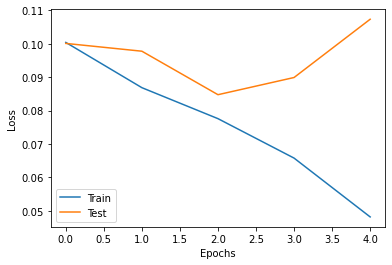

In [23]:
num_epochs = 5
%time model, losses = model_train(model, optimizer, criterion, scheduler)

from matplotlib import pyplot as plt
train_lo, test_lo = losses
epochs = range(num_epochs)
# list(train_lo)
plt.plot(epochs, train_lo)

plt.plot(epochs, test_lo)
plt.xlabel('Epochs')
plt.ylabel('Loss')


plt.legend(['Train', 'Test'])
plt.show()

label 비가 1:4로 unbalance하다.  
model saving의 기준을 test accuracy가 아닌 f1 score로 바꾸었다.  
train 및 test loss 모두 f1 loss이용  

그러나 F1 loss를 쓸 경우 학습 속도가 느리다.  
under fit 발생  
focal loss를 쓰는 것이 더 좋을 듯..

In [24]:
model.train(False)
data_loader = test_loader
running_corrects = 0
preds = []

# accuracy and loss
with torch.no_grad():   
    for _, pimages, labels in data_loader:
        pimages, labels = pimages.to(device), labels.to(device) 
        outputs = model(pimages)
        _, p = torch.max(outputs.data, 1)
        preds.append(p)
        
answer = []
for a,in zip(preds) :
    for i in a :
        answer.append((int(i)))
# print(answer)        

In [25]:
# confusion matrix and F1 score of ensenble
TP, FP, TN, FN = 0,0,0,0
for a, p in zip(test_df.Target, answer) :
    if a == 1 and p == 1 :
        TP += 1
    elif a == 1 and p == 0 :
        FN += 1
    elif a == 0 and p == 1 :
        FP += 1
    elif a == 0 and p == 0 :
        TN += 1

print('TP {}, FP {}, TN {}, FN {}'.format(TP, FP, TN, FN))   
Recall = TP / (TP + FN)
Precision = TP / (TP + FP)
Accuracy = (TP + TN) / (TP + FP + FN + TN)
F1_Score = 2 * (Recall * Precision) / (Recall + Precision)
print('Recall {:.4} precision {:.4}, accuracy {:.4}, F1 score {:.4}'.format(
    Recall, Precision, Accuracy, F1_Score))


TP 396, FP 198, TN 1857, FN 218
Recall 0.645 precision 0.6667, accuracy 0.8441, F1 score 0.6556
